# RESULTS
Here I report the full results of training of many different models.

There are a total of 81 different couples of parameters, for each a different model. ere I want to see how each model behaves.

In [1]:
import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import h5py

from pathlib import Path

%load_ext autoreload
%autoreload 2

In [2]:
prms = {'L' : 20,                # length of spin chain
        'sites' : [0, 1],        # sites of the subsystem S spins
        'omega' : 1,             # Rabi frequency
        # inverse temperature
        'beta' : [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
        # interaction of subsystem's S spins
        'potential' : [0.1, 0.15, 0.2, 0.25, 0.3],       
        'potential_' : None,     # interaction of bath spins, if None same as potential
        'T' : 10,                # total time for the evolution
        'dt' : 0.01,             # interval every which save the data
        'cutoff' : 1e-8,         # cutoff for TEBD algorithm
        'im_cutoff' : 1e-10,      # cutoff for TEBD algorithm, img t-e
        'tolerance' : 1e-3,      # Trotter tolerance for TEBD algorithm
        'verbose' : True,        # verbosity of the script
        'num_traj' : 20,         # how many trajectories to do
        # file to save the data
        'fname' : './data/data_tebd_test.hdf5'
        }

ml_params = {'model_dir': './data/trained_model', # folder where the metadata of the training are stored
             'validation_split' : 0.8,
             'batch_size': 256,
             #'batches_per_epoch': 256,
             'n_epochs': 20,
             'device': 'cpu',
             'mlp_params': {
                 'data_dim': 15,
                 'layers': [],
                 'nonlin': 'id',
                 'output_nonlin': 'id',
                 'dt' : 0.01
                 },
             }

In [35]:
def print_comparison(data_tebd, data_ml, T, dt, ylim):
    t = np.arange(0, T, dt)[:-1]
        
    rows= 5
    columns = 3

    fig, axs = plt.subplots(rows, columns, figsize=(15,15), dpi=80)
    plt.setp(axs, xlim=(0,T), ylim=(-ylim, ylim))

    for i in range(rows):
        for j in range(columns):
            #if i == rows-1 & j == columns-1:
            #    continue
            axs[i, j].plot(t, [data_tebd[k][(columns-1)*i+j] for k in range(len(t))], label='Simulation', color='k')
            axs[i, j].plot(t, [data_ml[k][(columns-1)*i+j] for k in range(len(t))], label='ml', color='r', linestyle='--')
            axs[i, j].grid()
    axs[4, 2].grid()
    #plt.legend()
    plt.grid()

    fig = plt.gcf()
    plt.show()

### Import models and error calculation

In [4]:
from ml.classes import MLLP
from ml.utils import calculate_error

In [68]:
# for each set of parameters I import the TEBD data, 
# import the model and predict dynamics, and calculate the error

errors = []

for beta in prms['beta']:
    err = []
    for vv in prms['potential']:
        # import TEBD data
        gname = 'cohVec_L_' + str(prms['L']) + \
                '_V_' + str(int(vv*1e3)).zfill(4) + \
                '_beta_' + str(int(beta*1e3)).zfill(4) + \
                '_dt_' + str(int(prms['dt']*1e3)).zfill(4)
        with h5py.File(prms['fname'], 'r') as f:
            data_tebd = f[gname+'/X'][()]

        # import the model
        name = 'model_L_' + str(prms['L']) + \
                '_V_' + str(int(vv*1e3)).zfill(4) + \
                '_beta_' + str(int(beta*1e3)).zfill(4) + \
                '_dt_' + str(int(prms['dt']*1e3)).zfill(4) + \
                '_T' + str(int(prms['T']))

        model = MLLP(ml_params['mlp_params'], beta).to(ml_params['device'])
        model.load_state_dict(torch.load(Path('./data/trained_not_rescaled/' + name)))
        
        # predict dynamics with the model
        ml_dyn = model.generate_trajectory(v_0=np.array(data_tebd[0]), T=prms['T'])
        
        # calculate error
        err.append(calculate_error(results_ml=ml_dyn, results_tebd=data_tebd, T=prms['T'], dt=prms['dt']))
    errors.append(err)

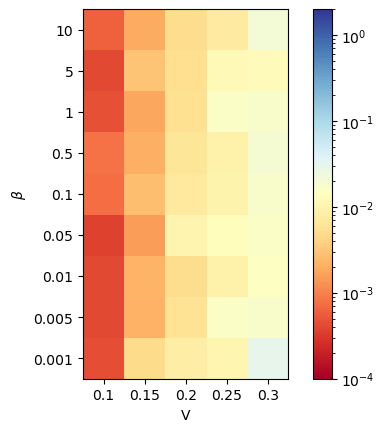

In [67]:
fig, ax = plt.subplots()

im = ax.imshow(errors, origin='lower', cmap='RdYlBu', norm=LogNorm(vmin=0.0001, vmax=2))

my_x_ticks = prms['potential']
my_y_ticks = prms['beta']
ax.set_xticks([i for i in range(len(my_x_ticks))])
ax.set_xticklabels(my_x_ticks)
ax.set_xlabel('V')
ax.set_yticks([i for i in range(len(my_y_ticks))])
ax.set_yticklabels(my_y_ticks)
ax.set_ylabel(r'$\beta$')

fig.colorbar(im, ax=ax)

plt.show()
#fig.savefig('../pictures/results_training_rescaled_data.pdf', dpi=150)

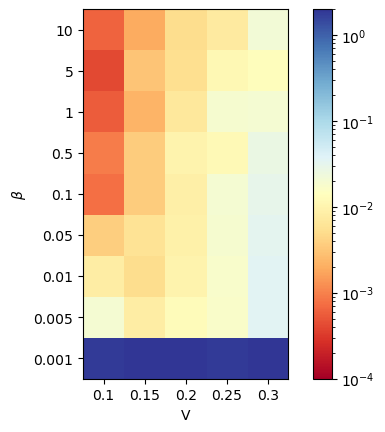

In [70]:
### WITHOUT DATA NORMALIZATION
fig, ax = plt.subplots()

im = ax.imshow(errors, origin='lower', cmap='RdYlBu', norm=LogNorm(vmin=0.0001, vmax=2))

my_x_ticks = prms['potential']
my_y_ticks = prms['beta']
ax.set_xticks([i for i in range(len(my_x_ticks))])
ax.set_xticklabels(my_x_ticks)
ax.set_xlabel('V')
ax.set_yticks([i for i in range(len(my_y_ticks))])
ax.set_yticklabels(my_y_ticks)
ax.set_ylabel(r'$\beta$')

fig.colorbar(im, ax=ax)

plt.show()
#fig.savefig('../pictures/results_training_not_rescaled_data.pdf', dpi=150)

### Is the model really dependent on the temperature?

In [71]:
# for each set of parameters I import the TEBD data, 
# import the model and predict dynamics, and calculate the error

errors_ = []

for beta in prms['beta']:
    err = []
    for vv in prms['potential']:
        # import TEBD data
        gname = 'cohVec_L_' + str(prms['L']) + \
                '_V_' + str(int(vv*1e3)).zfill(4) + \
                '_beta_' + str(int(beta*1e3)).zfill(4) + \
                '_dt_' + str(int(prms['dt']*1e3)).zfill(4)
        with h5py.File(prms['fname'], 'r') as f:
            data_tebd = f[gname+'/X'][()]

        # import the model
        name = 'model_L_' + str(prms['L']) + \
                '_V_' + str(int(vv*1e3)).zfill(4) + \
                '_beta_' + str(int(0.1*1e3)).zfill(4) + \
                '_dt_' + str(int(prms['dt']*1e3)).zfill(4) + \
                '_T' + str(int(prms['T']))

        model = MLLP(ml_params['mlp_params'], beta).to(ml_params['device'])
        model.load_state_dict(torch.load(Path('./data/trained_not_rescaled/' + name)))
        
        # predict dynamics with the model
        ml_dyn = model.generate_trajectory(v_0=np.array(data_tebd[0]), T=prms['T'])
        
        # calculate error
        err.append(calculate_error(results_ml=ml_dyn, results_tebd=data_tebd, T=prms['T'], dt=prms['dt']))
    errors_.append(err)

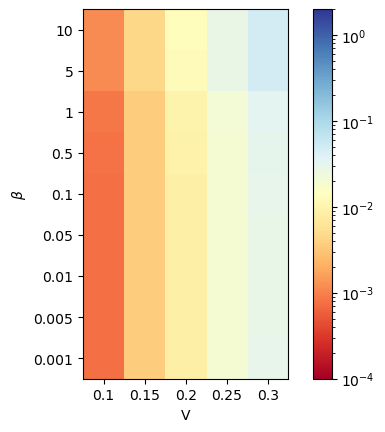

In [73]:
fig, ax = plt.subplots()

im = ax.imshow(errors_, origin='lower', cmap='RdYlBu', norm=LogNorm(vmin=0.0001, vmax=2))

my_x_ticks = prms['potential']
my_y_ticks = prms['beta']
ax.set_xticks([i for i in range(len(my_x_ticks))])
ax.set_xticklabels(my_x_ticks)
ax.set_xlabel('V')
ax.set_yticks([i for i in range(len(my_y_ticks))])
ax.set_yticklabels(my_y_ticks)
ax.set_ylabel(r'$\beta$')

fig.colorbar(im, ax=ax)

plt.show()
#fig.savefig('../pictures/results_training_same_beta.pdf', dpi=150)

### General model

In [122]:
for name, param in model.named_parameters():
    if param.requires_grad:
        print(name, param.data)

MLP.v_x tensor([[-1.5082e-02, -7.5193e-03, -1.4067e-03, -4.6625e-03, -2.7275e-03,
         -3.1689e-03, -5.4252e-04, -2.5855e-03, -6.2576e-04, -7.3647e-04,
         -5.3998e-05, -1.1229e-02, -3.2875e-04, -1.3800e-03, -1.9373e-03],
        [ 3.0628e-03,  2.1427e-03, -2.4631e-02,  1.3507e-02,  3.9609e-03,
          2.8432e-03, -1.6278e-04, -2.9789e-03, -1.6541e-04, -1.8038e-03,
         -9.8058e-04,  3.0853e-03,  1.6164e-03,  2.6726e-04,  1.6724e-03],
        [ 3.8101e-03, -1.2275e-03,  1.0255e-03,  2.1151e-03, -3.9020e-04,
         -5.9253e-06, -4.2111e-03,  3.4502e-03, -9.2466e-04, -2.7264e-03,
          2.3578e-03,  7.6428e-04,  4.4492e-03, -7.3066e-04, -1.0887e-03],
        [ 1.1516e-02, -3.8706e-03,  5.8542e-03,  7.3784e-05, -2.0364e-03,
         -1.1851e-03, -3.6983e-03,  1.3626e-02, -2.9136e-05, -1.1600e-03,
          2.2491e-03,  4.5241e-03,  1.4172e-03,  1.2092e-03, -3.9535e-03],
        [ 1.8791e-02,  1.7163e-03, -2.9436e-04,  1.5995e-02, -1.2055e-03,
         -6.5766e-04,  2.7

In [118]:
# for each set of parameters I import the TEBD data, 
# import the model and predict dynamics, and calculate the error

# import the model
name = 'model_L_' + str(prms['L']) + \
        '_T' + str(int(prms['T']))

model = MLLP(ml_params['mlp_params'], beta).to(ml_params['device'])
model.load_state_dict(torch.load(Path('./data/trained_single/' + name)))

errors_ = []

for beta in prms['beta']:
    err = []
    for vv in prms['potential']:
        # import TEBD data
        gname = 'cohVec_L_' + str(prms['L']) + \
                '_V_' + str(int(vv*1e3)).zfill(4) + \
                '_beta_' + str(int(beta*1e3)).zfill(4) + \
                '_dt_' + str(int(prms['dt']*1e3)).zfill(4)
        with h5py.File(prms['fname'], 'r') as f:
            data_tebd = f[gname+'/X'][()]

        # predict dynamics with the model
        ml_dyn = model.generate_trajectory(v_0=np.array(data_tebd[0]), T=prms['T'], 
                                           potential=[vv], beta=beta)
        
        # calculate error
        err.append(calculate_error(results_ml=ml_dyn, results_tebd=data_tebd, T=prms['T'], dt=prms['dt']))
    errors_.append(err)

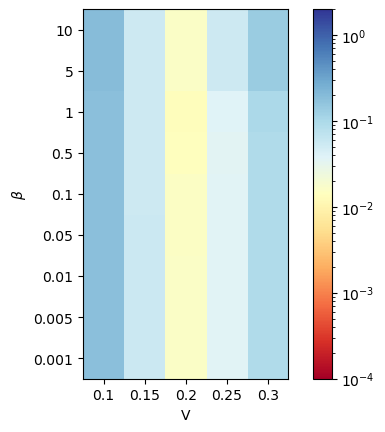

In [119]:
fig, ax = plt.subplots()

im = ax.imshow(errors_, origin='lower', cmap='RdYlBu', norm=LogNorm(vmin=0.0001, vmax=2))

my_x_ticks = prms['potential']
my_y_ticks = prms['beta']
ax.set_xticks([i for i in range(len(my_x_ticks))])
ax.set_xticklabels(my_x_ticks)
ax.set_xlabel('V')
ax.set_yticks([i for i in range(len(my_y_ticks))])
ax.set_yticklabels(my_y_ticks)
ax.set_ylabel(r'$\beta$')

fig.colorbar(im, ax=ax)

plt.show()
#fig.savefig('../pictures/results_training_same_beta.pdf', dpi=150)

In [ ]:
# perche' a temeprature alte fa schifo?
# import TEBD data
beta = 0.001
vv = 0.1

gname = 'cohVec_L_' + str(prms['L']) + \
        '_V_' + str(int(vv*1e3)).zfill(4) + \
        '_beta_' + str(int(beta*1e3)).zfill(4) + \
        '_dt_' + str(int(prms['dt']*1e3)).zfill(4)
with h5py.File(prms['fname'], 'r') as f:
    data_tebd = f[gname+'/X'][()]

# import the model
name = 'model_L_' + str(prms['L']) + \
        '_T' + str(int(prms['T']))
        #'_V_' + str(int(vv*1e3)).zfill(4) + \
        #'_beta_' + str(int(beta*1e3)).zfill(4) + \
        #'_dt_' + str(int(prms['dt']*1e3)).zfill(4) + \
        #'_T' + str(int(prms['T']))

model = MLLP(ml_params['mlp_params'], beta).to(ml_params['device'])
model.load_state_dict(torch.load(Path('./data/trained_single/' + name)))

# predict dynamics with the model
ml_dyn = model.generate_trajectory(v_0=np.array(data_tebd[0]), T=prms['T'], 
                                   potential=vv, beta=beta)

print(calculate_error(results_ml=ml_dyn, results_tebd=data_tebd, T=prms['T'], dt=prms['dt']))

print_comparison(data_tebd, ml_dyn, prms['T'], prms['dt'], 1-math.e**(-beta/2))